# Regression Analysis of Temporal Processes (Class 7) - Intro to Time Series

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

/Users/melindasong/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/melindasong/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/melindasong/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Grab the data that we need
GSS = pd.read_csv('trends-gss.csv')
variables = ["year", "confinan", "sex", "age", "partyid", "wrkstat", "degree"]
sub = GSS[variables].copy()

In [3]:
# Recoding variables and creating indicator variables
sub['n_confinan'] = sub['confinan'].replace([1, 3], [3, 1])

sub['baplus'] = np.where(sub['degree']>=3, 1, 0)
sub['fulltime'] = np.where(sub['wrkstat']==1, 1, 0)
sub['womenft'] = np.where((sub['sex']==2) & (sub['wrkstat']==1), 1, 0)
sub['degreelt50'] = np.where((sub['baplus']==1) & (sub['age']<50), 1, 0)
sub['partyid6'] = np.where(sub['partyid']==6, 1, 0)
sub['partyid7'] = np.where(sub['partyid']==7, 1, 0)

by_year = sub.groupby('year', as_index = False).agg("mean")

In [4]:
# add additional years to the dataframe by creating a separate dataframe for the new years and appending it to the original dataframe
add_years_df = pd.DataFrame(data = pd.Series([1979, 1981, 1992, 1995, 1997, 1999, 2001, 2003, 2005, 2007, 2009]), columns = ['year'])
by_year = pd.concat([by_year, add_years_df], sort = False, ignore_index = True)


In [5]:
# (slide 6)
by_year = by_year.sort_values(['year'])

by_year['year'] = pd.to_datetime(by_year['year'], format = "%Y")
by_year = by_year.set_index('year', drop = False)

by_year_ts = by_year.interpolate(method = 'linear')

In [6]:
by_year_ts.head()

,year,confinan,sex,age,partyid,wrkstat,degree,n_confinan,baplus,fulltime,womenft,degreelt50,partyid6,partyid7
year,,,,,,,,,,,,,,
1972-01-01,1972-01-01,NaN,1.499690,44.950871,2.505912,3.455673,0.865409,NaN,0.109113,0.464972,0.124613,0.076255,0.078115,0.042777
1973-01-01,1973-01-01,NaN,1.533910,44.182000,2.693905,3.573803,0.950974,NaN,0.130984,0.432846,0.137633,0.097074,0.081782,0.041223
1974-01-01,1974-01-01,NaN,1.534367,44.591340,2.598220,3.585580,0.998651,NaN,0.142857,0.427898,0.145553,0.102426,0.074124,0.039757
1975-01-01,1975-01-01,1.785319,1.550336,44.307744,2.501010,3.575168,0.952317,2.214681,0.127517,0.417450,0.157047,0.098658,0.062416,0.008054
1976-01-01,1976-01-01,1.697115,1.553702,45.286671,2.430769,3.625083,0.988614,2.302885,0.142095,0.412942,0.150100,0.101401,0.064043,0.002668


In [6]:
by_year_ts['repub'] = by_year_ts['partyid6'] + by_year_ts['partyid7']
by_year_ts['repub_pct'] = by_year_ts['repub']*100
by_year_ts['fulltime_pct'] = by_year_ts['fulltime']*100
by_year_ts['degreelt50_pct'] = by_year_ts['degreelt50']*100

# convert 'year' back to integer in order to allow model-fitting
by_year_ts['year'] = by_year_ts['year'].dt.year

# subset the dataset to only look at 1992 and earlier
by_year_ts2 = by_year_ts[by_year_ts['year']<=1992].copy()


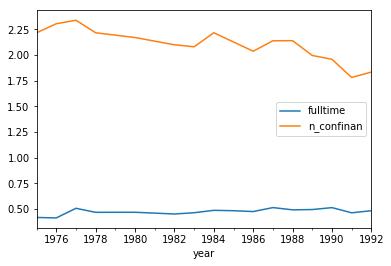

In [14]:
# (slide 8)

by_year_ts2.loc[:, ['fulltime', 'n_confinan']].plot(xlim = ('1975-01-01', '1992-01-01'))

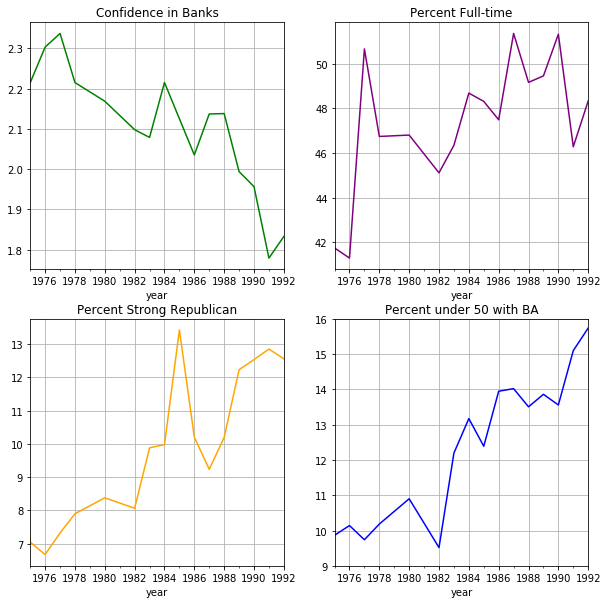

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

by_year_ts2['n_confinan'].plot(xlim = ('1975-01-01', '1992-01-01'), title = 'Confidence in Banks', color = 'g', ax = axes[0,0], grid = True)
by_year_ts2['fulltime_pct'].plot(xlim = ('1975-01-01', '1992-01-01'), title = 'Percent Full-time', color = 'purple', ax = axes[0,1], grid = True)
by_year_ts2['repub_pct'].plot(xlim = ('1975-01-01', '1992-01-01'), title = 'Percent Strong Republican', color = 'orange', ax = axes[1,0], grid = True)
by_year_ts2['degreelt50_pct'].plot(xlim = ('1975-01-01', '1992-01-01'), ylim = (9, 16), title = 'Percent under \
50 with BA', color = 'b', ax = axes[1,1], grid = True)

In [9]:
# (slide 12)

cor_vars = ["n_confinan", "fulltime_pct", "repub_pct", "degreelt50_pct", "year"]
cor_dat = by_year_ts2[cor_vars].copy()

cor_dat.corr()

,n_confinan,fulltime_pct,repub_pct,degreelt50_pct,year
n_confinan,1.000000,-0.229029,-0.795358,-0.776779,-0.854655
fulltime_pct,-0.229029,1.000000,0.285045,0.537870,0.643588
repub_pct,-0.795358,0.285045,1.000000,0.473364,0.429449
degreelt50_pct,-0.776779,0.537870,0.473364,1.000000,0.929227
year,-0.854655,0.643588,0.429449,0.929227,1.000000


In [16]:
# (slide 13)

lm_confinan = smf.ols('n_confinan ~ fulltime_pct', data = by_year_ts2).fit()
lm_confinan.summary()

/Users/melindasong/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             n_confinan   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.8857
Date:                Mon, 13 Aug 2018   Prob (F-statistic):              0.361
Time:                        14:02:51   Log-Likelihood:                 10.059
No. Observations:                  18   AIC:                            -16.12
Df Residuals:                      16   BIC:                            -14.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.6772      0.605      4.424      0.000       1.394       3.960
fulltime_pct    -0.0120      0.013     -0.941      0.361      -0.039       0.015
==============================================================================
Omnibus:                        4.101   Durbin-Watson:                   0.618
Prob(Omnibus):                  0.129   Jarque-Bera (JB):                2.010
Skew:                          -0.738   Prob(JB):                        0.366
Kurtosis:                       3.709   Cond. No.                         829.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Test for heteroskedasticity

In [11]:
# (slide 14)

from statsmodels.compat import lzip
name = ['BP', 'p-value', 
        'f-value', 'f p-value']

# use results of the model we fitted earlier
test = sm.stats.diagnostic.het_breuschpagan(lm_confinan.resid, lm_confinan.model.exog)
lzip(name, test)

[('BP', 0.26327533666908876),
 ('p-value', 0.6078788313898792),
 ('f-value', 0.2374962382662567),
 ('f p-value', 0.6326299442699024)]

There's no evidence of heteroskedasticity in the above regression

### Look for autocorrelation in the errors

The `statsmodels` module contains functions that calculate and plot ACF for us: 

In [17]:
# (slide 15)

err = lm_confinan.resid

from statsmodels.tsa.stattools import acf

acf(err)

array([ 1.        ,  0.58796147,  0.22189358,  0.12035591, -0.05046713,
       -0.04474988, -0.01771699, -0.03907582,  0.02183761,  0.05436172,
        0.03683238, -0.0493235 , -0.18946037, -0.26367996, -0.38893786,
       -0.33786383, -0.13203339, -0.02993395])

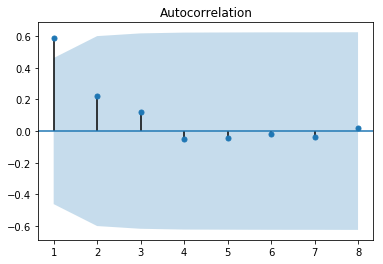

In [18]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(err, lags = 8, zero = False);

### Test for autocorrelation in the errors

`statsmodels` also supports the Durbin Watson test: 

(slide 21)

In [19]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(err)

0.6182171332370635

Although the above function does not return a p-value, the documentation does note that the test statistics is always between 0 and 4, with 2 indicating no serial correlation. The closer to 0 the statistic, the more evidence for positive serial correlation. The closer to 4, the more evidence for negative serial correlation. 

In [20]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

lmtest, pval, fval, f_pval = acorr_breusch_godfrey(lm_confinan, nlags = 1)
print('LM test =', lmtest)
print('p-value =', pval)

LM test = 8.00990145481169
p-value = 0.004652226925459141


### Any higher order autocorrelation?

In [ ]:
Since no equivalent of the `durbinWatsonTest` function in R seems to be available in Python

In [7]:
from rpy2.robjects.packages import importr

car = importr('car')
stats = importr('stats')

%load_ext rpy2.ipython

In [23]:
%%R -i by_year_ts2

# refit the model using lm function from R
lm_confinan_r = lm(n_confinan ~ fulltime_pct, data = by_year_ts2)

# pass the model to function
durbinWatsonTest(lm_confinan_r, max.lag=3)

/Users/melindasong/anaconda/envs/py36/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


 lag Autocorrelation D-W Statistic p-value
   1       0.5879615     0.6182171   0.000
   2       0.2218936     0.9685850   0.038
   3       0.1203559     0.9313264   0.048
 Alternative hypothesis: rho[lag] != 0


## The problem of serial correlation

We refit the previous model. In this version we add time as the second variable in order to net out the time dimension for `n_confinan` and `fulltime_pct`.

In order to fit this model using ols, we need to convert the `year` variable to integers from time series. 

In [24]:
# (slide 31)

lm_confinan2 = smf.ols('n_confinan ~ fulltime_pct + year', data = by_year_ts2).fit()
lm_confinan2.summary()

/Users/melindasong/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             n_confinan   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     41.00
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           8.32e-07
Time:                        15:27:03   Log-Likelihood:                 26.374
No. Observations:                  18   AIC:                            -46.75
Df Residuals:                      15   BIC:                            -44.08
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       60.9310      6.647      9.166      0.000      46.763      75.099
fulltime_pct     0.0220      0.007      3.339      0.004       0.008       0.036
year            -0.0302      0.003     -8.770      0.000      -0.038      -0.023
==============================================================================
Omnibus:                        3.603   Durbin-Watson:                   1.475
Prob(Omnibus):                  0.165   Jarque-Bera (JB):                2.618
Skew:                           0.925   Prob(JB):                        0.270
Kurtosis:                       2.744   Cond. No.                     9.14e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.14e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

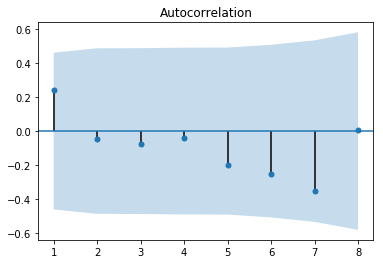

In [11]:
# (slide 32)
err2 = lm_confinan2.resid

plot_acf(err2, lags = 8, zero = False);

Text(0,0.5,'error2')

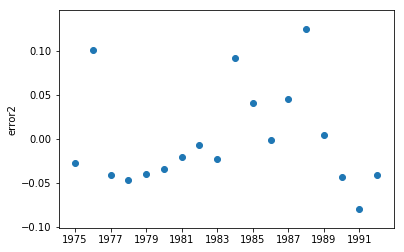

In [17]:
# (slide 35)

import pylab
pylab.scatter(err2.index, err2)
pylab.ylabel('error2')

In [18]:
# (slide 36)
durbin_watson(err2)

1.475495747490274

In [31]:
lmtest, pval, fval, f_pval = acorr_breusch_godfrey(lm_confinan2, nlags = 1)
print('LM test =', lmtest)
print('p-value =', pval)

LM test = 1.3349802982411745
p-value = 0.24792114641916022


In [19]:
sm.stats.diagnostic.het_breuschpagan(lm_confinan2.resid, lm_confinan2.model.exog)

(0.5641262278076062,
 0.7542260808785642,
 0.24265756702739885,
 0.7875607859152058)

In [26]:
%%R -i by_year_ts2

lm_confinan2_r = lm(n_confinan ~ fulltime_pct + year, data = by_year_ts2)

durbinWatsonTest(lm_confinan2_r, max.lag = 3)

 lag Autocorrelation D-W Statistic p-value
   1      0.24031336      1.475496   0.110
   2     -0.04599553      1.755263   0.564
   3     -0.07821943      1.755780   0.750
 Alternative hypothesis: rho[lag] != 0


#### What if we used the data from all years instead of 1992 and earlier
(slide 38)

In [27]:
smf.ols('n_confinan ~ fulltime_pct + year', data = by_year_ts).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             n_confinan   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     12.42
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           8.91e-05
Time:                        15:28:14   Log-Likelihood:                 29.024
No. Observations:                  37   AIC:                            -52.05
Df Residuals:                      34   BIC:                            -47.22
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       20.8888      3.828      5.456      0.000      13.109      28.669
fulltime_pct     0.0153      0.006      2.686      0.011       0.004       0.027
year            -0.0098      0.002     -4.960      0.000      -0.014      -0.006
==============================================================================
Omnibus:                        0.894   Durbin-Watson:                   0.303
Prob(Omnibus):                  0.640   Jarque-Bera (JB):                0.899
Skew:                          -0.333   Prob(JB):                        0.638
Kurtosis:                       2.625   Cond. No.                     4.03e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## What if we still have serial correlation in the errors left, even after incorporating the trend variable?

In [28]:
# (slide 42)

lm_confinan3 = smf.ols('n_confinan ~ fulltime_pct + year + repub_pct + degreelt50_pct', 
                       data = by_year_ts2).fit()
lm_confinan3.summary()

/Users/melindasong/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             n_confinan   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     19.23
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           2.28e-05
Time:                        15:28:19   Log-Likelihood:                 26.980
No. Observations:                  18   AIC:                            -43.96
Df Residuals:                      13   BIC:                            -39.51
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         63.8249     19.067      3.347      0.005      22.632     105.018
fulltime_pct       0.0223      0.007      3.239      0.006       0.007       0.037
year              -0.0317      0.010     -3.235      0.007      -0.053      -0.011
repub_pct         -0.0101      0.015     -0.657      0.522      -0.043       0.023
degreelt50_pct     0.0144      0.020      0.710      0.490      -0.029       0.058
==============================================================================
Omnibus:                        2.687   Durbin-Watson:                   1.537
Prob(Omnibus):                  0.261   Jarque-Bera (JB):                2.110
Skew:                           0.797   Prob(JB):                        0.348
Kurtosis:                       2.476   Cond. No.                     2.52e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.52e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Looking into the variance inflation factors (VIFs)
(slide 43)

The `statsmodel` module provides a function that calculates the variance inflation factors, which requires a design matrix with all the explanatory variables. We can construct this design matrix using the `dmatrices` function from `patsy`.

In [59]:
from patsy import dmatrices
y, X = dmatrices('n_confinan ~ fulltime_pct + year_int + repub_pct + degreelt50_pct', 
                 data = by_year_ts, return_type = 'dataframe')

In [62]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
vif

,VIF Factor,features
0,1.617823e+06,Intercept
1,1.546214e+00,fulltime_pct
2,1.149002e+01,year_int
3,4.712469e+00,repub_pct
4,7.135015e+00,degreelt50_pct


#### Autocorrelation tests
(slide 45)

In [30]:
%%R -i by_year_ts2

# refit the model using lm function from R
lm_confinan3_r = lm(n_confinan ~ fulltime_pct + year + repub_pct + degreelt50_pct, data = by_year_ts2)

# pass the model to function
durbinWatsonTest(lm_confinan3_r, max.lag=2)

 lag Autocorrelation D-W Statistic p-value
   1      0.19572438      1.536660   0.146
   2     -0.09059041      1.838454   0.878
 Alternative hypothesis: rho[lag] != 0


In [125]:
# (slide 49)
smf.ols('n_confinan ~ fulltime_pct + year + repub_pct + degreelt50_pct', data = by_year_ts).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             n_confinan   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     11.47
Date:                Sat, 21 Jul 2018   Prob (F-statistic):           6.86e-06
Time:                        13:35:16   Log-Likelihood:                 35.333
No. Observations:                  37   AIC:                            -60.67
Df Residuals:                      32   BIC:                            -52.61
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.0746      5.346      1.136      0.264      -4.816      16.965
fulltime_pct       0.0294      0.006      4.608      0.000       0.016       0.042
year              -0.0024      0.003     -0.867      0.392      -0.008       0.003
repub_pct         -0.0106      0.015     -0.720      0.477      -0.041       0.019
degreelt50_pct    -0.0455      0.017     -2.755      0.010      -0.079      -0.012
==============================================================================
Omnibus:                        4.199   Durbin-Watson:                   0.666
Prob(Omnibus):                  0.123   Jarque-Bera (JB):                3.213
Skew:                           0.714   Prob(JB):                        0.201
Kurtosis:                       3.207   Cond. No.                     6.48e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.48e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<br>

From the tests above, it seems like we don't have serial correlation in our errors.

## But what should we do if we found serial correlation?

### Solution #1: apply autocorrelation-robust standard errors
(slide 54)

In [129]:
lm_confinan3.get_robustcov_results(cov_type = 'HAC', maxlags=1).summary()

/Users/melindasong/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1390: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             n_confinan   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     21.41
Date:                Sat, 21 Jul 2018   Prob (F-statistic):           1.26e-05
Time:                        13:41:27   Log-Likelihood:                 26.980
No. Observations:                  18   AIC:                            -43.96
Df Residuals:                      13   BIC:                            -39.51
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         63.8249     15.903      4.013      0.001      29.468      98.182
fulltime_pct       0.0223      0.007      3.327      0.005       0.008       0.037
year              -0.0317      0.008     -3.885      0.002      -0.049      -0.014
repub_pct         -0.0101      0.017     -0.589      0.566      -0.047       0.027
degreelt50_pct     0.0144      0.009      1.549      0.145      -0.006       0.035
==============================================================================
Omnibus:                        2.687   Durbin-Watson:                   1.537
Prob(Omnibus):                  0.261   Jarque-Bera (JB):                2.110
Skew:                           0.797   Prob(JB):                        0.348
Kurtosis:                       2.476   Cond. No.                     2.52e+06
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
[2] The condition number is large, 2.52e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Solution #2: Take the first differences of your equation instead of the levels
(slide 57)

In [13]:
by_yearFD = pd.DataFrame()

# grab the variables from by_year_ts2 that we want to take the first differences of
by_yearFD = by_year_ts[['n_confinan', 'fulltime_pct', 'repub_pct', 'degreelt50_pct']]
by_yearFD = by_yearFD.diff()

by_yearFD['year'] = by_year_ts['year']

In [160]:
by_yearFD.head()

,n_confinan,fulltime_pct,repub_pct,degreelt50_pct,year
year,,,,,
1972-01-01,NaN,NaN,NaN,NaN,1972
1973-01-01,NaN,-3.212636,0.211257,2.081904,1973
1974-01-01,NaN,-0.494817,-0.912392,0.535141,1974
1975-01-01,NaN,-1.044791,-4.341160,-0.376816,1975
1976-01-01,0.088203,-0.450770,-0.375866,0.274322,1976


In [14]:
by_yearFD2 = by_yearFD[by_yearFD['year']<=1992]

In [15]:
lm_confinan4 = smf.ols('n_confinan ~ fulltime_pct + year + repub_pct + degreelt50_pct', data = by_yearFD2).fit()
lm_confinan4.summary()

/Users/melindasong/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1390: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             n_confinan   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     2.253
Date:                Fri, 10 Aug 2018   Prob (F-statistic):              0.124
Time:                        15:24:11   Log-Likelihood:                 22.701
No. Observations:                  17   AIC:                            -35.40
Df Residuals:                      12   BIC:                            -31.24
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.9401      7.613      0.518      0.614     -12.647      20.527
fulltime_pct       0.0155      0.006      2.545      0.026       0.002       0.029
year              -0.0020      0.004     -0.520      0.612      -0.010       0.006
repub_pct         -0.0152      0.014     -1.095      0.295      -0.045       0.015
degreelt50_pct    -0.0042      0.021     -0.199      0.846      -0.050       0.042
==============================================================================
Omnibus:                        0.610   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.737   Jarque-Bera (JB):                0.662
Skew:                           0.306   Prob(JB):                        0.718
Kurtosis:                       2.252   Cond. No.                     8.22e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.22e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0,0.5,'error')

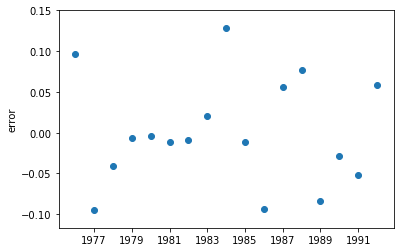

In [18]:
fd_err = lm_confinan4.resid

pylab.scatter(fd_err.index, fd_err)
pylab.ylabel('error')

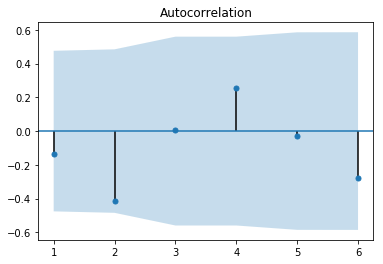

In [19]:
plot_acf(fd_err, lags = 6, zero = False);

<br>

With full set of years:

In [166]:
smf.ols('n_confinan ~ fulltime_pct + year + repub_pct + degreelt50_pct', data = by_yearFD).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             n_confinan   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     5.601
Date:                Sat, 21 Jul 2018   Prob (F-statistic):            0.00164
Time:                        14:10:06   Log-Likelihood:                 50.964
No. Observations:                  36   AIC:                            -91.93
Df Residuals:                      31   BIC:                            -84.01
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.4764      2.107     -0.226      0.823      -4.773       3.820
fulltime_pct       0.0207      0.005      4.521      0.000       0.011       0.030
year               0.0002      0.001      0.219      0.828      -0.002       0.002
repub_pct         -0.0104      0.010     -1.050      0.302      -0.031       0.010
degreelt50_pct     0.0063      0.012      0.516      0.610      -0.019       0.031
==============================================================================
Omnibus:                        1.349   Durbin-Watson:                   1.697
Prob(Omnibus):                  0.510   Jarque-Bera (JB):                1.301
Skew:                          -0.410   Prob(JB):                        0.522
Kurtosis:                       2.558   Cond. No.                     3.98e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.98e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Solution #3: Do a feasible GLS regression, which is quasi-differenced -- i.e., Prais-Winston or Cochrane-Orcutt

In [8]:
orcutt = importr('orcutt')

In [10]:
dir(orcutt)

['_Random_seed',
 '___NAMESPACE___',
 '___S3MethodsTable___',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__rdata__',
 '__rname__',
 '__spec__',
 '__version__',
 '_env',
 '_exported_names',
 '_packageName',
 '_rpy2r',
 '_symbol_check_after',
 '_symbol_r2python',
 '_translation',
 'cochrane_orcutt',
 'predict_orcutt',
 'print_orcutt',
 'print_summary_orcutt',
 'residual_orcutt',
 'summary_orcutt']

In [12]:
%%R -i by_year_ts2

lm_confinan3_r = lm(n_confinan ~ fulltime_pct + year + repub_pct + degreelt50_pct, data = by_year_ts2)
cochrane_orcutt(lm_confinan3_r)


Error in cochrane_orcutt(lm_confinan3_r) : 
  could not find function "cochrane_orcutt"


/Users/melindasong/anaconda/envs/py36/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in cochrane_orcutt(lm_confinan3_r) : 
  could not find function "cochrane_orcutt"

  warnings.warn(x, RRuntimeWarning)
